In [262]:
import os
import sys

root_dir = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
model_dir = os.path.join(root_dir, "model")
sys.path.append(root_dir)
sys.path.append(model_dir)

import time
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hoho_utils


plt.style.use('ggplot')

In [223]:
def suffix_time():
    current_time = time.time()
    local_time = time.localtime(current_time)
    time_str = time.strftime('%Y%m%d%H%M%S', local_time)
    return time_str

In [224]:
suffix = suffix_time()
suffix

'20230919092321'

### 加载走子数据

In [225]:
data_dir = "../output/data"
file_list = os.listdir(data_dir)
file_count = len(file_list)
item_list = list()

print(f"file_count: {file_count}")

for i, filename in enumerate(file_list):
    file_path = os.path.join(data_dir, filename)
    with open(file_path, "r") as file:
        json_str = file.read()
        matches = json.loads(json_str)
        match_count = len(matches)

        for j, match in enumerate(matches):
            base_id =  int(time.time() * 1000) + j
            for k, round in enumerate(match):
                match_id = f"{i}-{j}"
                round_id = f"{base_id}-{k}"
                state = round[0]
                action = round[2]
                next_state = round[3]
                raw_reward = round[4]
                done = round[5]
                chapture_list = round[6]
                chaptures = ','.join(chapture_list)
                chapture_reward = round[7]
                re_reward = round[8]

                round_dict = {"match_id": match_id,
                              "round_id": round_id,
                              "state": state,
                              "action":action,
                              "next_state": next_state,
                              "done": done,
                              "chaptures": chaptures,
                              "chapture_reward": chapture_reward,
                              "raw_reward": raw_reward,
                              "re_reward": re_reward}
                item_list.append(round_dict)

                if done:
                    break

file_count: 102


In [226]:
data = pd.DataFrame(item_list)

In [227]:
data

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,raw_reward,re_reward
0,0-0,1695086605612-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,h0i2,RNBAKAB1R/9/1C5CN/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,False,,0.00,0,-1.8100
1,0-0,1695086605612-1,RNBAKAB1R/9/1C5CN/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,b2e2,RNBAKAB1R/9/4C2CN/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,False,,0.00,0,-1.9000
2,0-0,1695086605612-2,RNBAKAB1R/9/4C2CN/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,e0e1,RNBA1AB1R/4K4/4C2CN/P1P1c1P1P/9/9/p1p1p1p1p/1c...,False,P,-1.00,0,-3.7549
3,0-0,1695086605612-3,RNBA1AB1R/4K4/4C2CN/P1P1c1P1P/9/9/p1p1p1p1p/1c...,e1e0,RNBAKAB1R/9/4C2CN/P1P1c1P1P/9/9/p1p1p1p1p/1c4n...,False,,0.00,0,-3.9610
4,0-0,1695086605612-4,RNBAKAB1R/9/4C2CN/P1P1c1P1P/9/9/p1p1p1p1p/1c4n...,g3g4,RNBAKAB1R/9/4C2rN/P1P1c3P/6P2/9/p1p1p1p1p/1c4n...,False,C,-2.29,0,-84.8710
...,...,...,...,...,...,...,...,...,...,...
6677,101-6,1695086608067-4,RNBA1AB1R/4K4/4C2CN/P3c1P1P/2P6/9/p1p1p1p1p/1c...,e2g2,RNBA1AB1R/4K4/6CrN/P3c1P1P/2P6/9/p1p1p1p1p/1c4...,False,C,-2.29,0,-5.9320
6678,101-6,1695086608067-5,RNBA1AB1R/4K4/6CrN/P3c1P1P/2P6/9/p1p1p1p1p/1c4...,a0a1,1NBA1AB1R/R3K4/6r1N/P3c1P1P/2P6/9/p1p1p1p1p/1c...,False,C,-2.29,0,-5.1220
6679,101-6,1695086608067-6,1NBA1AB1R/R3K4/6r1N/P3c1P1P/2P6/9/p1p1p1p1p/1c...,a1a2,1NBA1AB1R/4K4/Rc4r1N/P3c1P1P/2P6/9/p1p1p1p1p/6...,False,,0.00,0,-84.0610
6680,101-6,1695086608067-7,1NBA1AB1R/4K4/Rc4r1N/P3c1P1P/2P6/9/p1p1p1p1p/6...,i3i4,1NBA1AB1R/4K4/R3c1r1N/P3c1P2/2P5P/9/p1p1p1p1p/...,False,,0.00,0,-90.7939


In [228]:
data.to_excel(f"./outputs/hoho_chess_data_{suffix}.xlsx", index = False)

### 看看随着模型不断学习升级，累积奖励的趋势

In [229]:
data_group = data.groupby(["match_id"], as_index = False).agg({"re_reward": sum, "chapture_reward": sum})
data_group

,match_id,re_reward,chapture_reward
0,0-0,-282.2128,-103.29
1,0-1,-331.0256,-111.58
2,0-10,-294.8056,-106.58
3,0-2,-326.8335,-112.87
4,0-3,-282.2128,-103.29
...,...,...,...
787,99-1,-282.2128,-103.29
788,99-2,-282.2128,-103.29
789,99-3,-282.2128,-103.29
790,99-4,-282.2128,-103.29


In [230]:
data_group["model_version"] = data_group["match_id"].apply(lambda x: x.split("-")[0]).astype(int)
data_group

,match_id,re_reward,chapture_reward,model_version
0,0-0,-282.2128,-103.29,0
1,0-1,-331.0256,-111.58,0
2,0-10,-294.8056,-106.58,0
3,0-2,-326.8335,-112.87,0
4,0-3,-282.2128,-103.29,0
...,...,...,...,...
787,99-1,-282.2128,-103.29,99
788,99-2,-282.2128,-103.29,99
789,99-3,-282.2128,-103.29,99
790,99-4,-282.2128,-103.29,99


In [231]:
data_group_sorted = data_group.sort_values(by = "model_version").reset_index()
data_group_sorted

,index,match_id,re_reward,chapture_reward,model_version
0,0,0-0,-282.2128,-103.29,0
1,1,0-1,-331.0256,-111.58,0
2,2,0-10,-294.8056,-106.58,0
3,3,0-2,-326.8335,-112.87,0
4,4,0-3,-282.2128,-103.29,0
...,...,...,...,...,...
787,42,101-4,-282.2128,-103.29,101
788,41,101-3,-282.2128,-103.29,101
789,40,101-2,-282.2128,-103.29,101
790,39,101-1,-282.2128,-103.29,101


In [232]:
data_group_sorted["match_index"] = data_group_sorted["match_id"].apply(lambda x: x.split("-")[-1]).astype(int)

In [233]:
data_group_sorted

,index,match_id,re_reward,chapture_reward,model_version,match_index
0,0,0-0,-282.2128,-103.29,0,0
1,1,0-1,-331.0256,-111.58,0,1
2,2,0-10,-294.8056,-106.58,0,10
3,3,0-2,-326.8335,-112.87,0,2
4,4,0-3,-282.2128,-103.29,0,3
...,...,...,...,...,...,...
787,42,101-4,-282.2128,-103.29,101,4
788,41,101-3,-282.2128,-103.29,101,3
789,40,101-2,-282.2128,-103.29,101,2
790,39,101-1,-282.2128,-103.29,101,1


In [234]:
data_group_sorted2 = data_group_sorted.groupby("model_version").apply(lambda x: x.sort_values(by = "match_index"))
data_group_sorted3 = data_group_sorted2.reset_index(drop = True)

In [235]:
data_group_sorted3

,index,match_id,re_reward,chapture_reward,model_version,match_index
0,0,0-0,-282.2128,-103.29,0,0
1,1,0-1,-331.0256,-111.58,0,1
2,3,0-2,-326.8335,-112.87,0,2
3,4,0-3,-282.2128,-103.29,0,3
4,5,0-4,-356.6905,-118.58,0,4
...,...,...,...,...,...,...
787,40,101-2,-282.2128,-103.29,101,2
788,41,101-3,-282.2128,-103.29,101,3
789,42,101-4,-282.2128,-103.29,101,4
790,43,101-5,-282.2128,-103.29,101,5


In [236]:
data_group_sorted3.to_excel(f"./outputs/hoho_qlearning_total_rewards_data_by_match_{suffix}.xlsx", index = False)

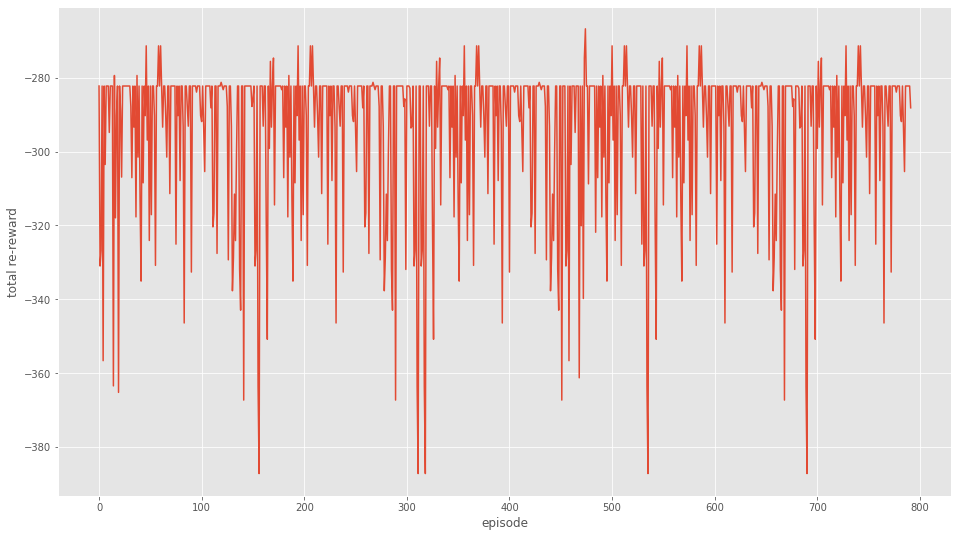

In [239]:
x = range(data_group_sorted3["re_reward"].values.shape[0])
y = data_group_sorted3["re_reward"].values
plt.figure(figsize = (16, 9))
plt.plot(x, y)
plt.xlabel("episode")
plt.ylabel("total re-reward")
plt.show()

In [240]:
data_group_sorted4 = data_group_sorted3.groupby("model_version").agg({"re_reward": sum, "chapture_reward": sum, "match_index": "count"}).reset_index()
data_group_sorted4.rename(columns = {"match_index": "match_count"}, inplace = True)
data_group_sorted4["average_chapture_reward"] = data_group_sorted4["chapture_reward"] / data_group_sorted4["match_count"]
data_group_sorted4["average_re_reward"] = data_group_sorted4["re_reward"] / data_group_sorted4["match_count"]
data_group_sorted4

,model_version,re_reward,chapture_reward,match_count,average_chapture_reward,average_re_reward
0,0,-3306.1248,-1176.64,11,-106.967273,-300.556800
1,1,-3027.4443,-1076.06,10,-107.606000,-302.744430
2,2,-4306.1250,-1570.64,15,-104.709333,-287.075000
3,3,-3842.8129,-1380.93,13,-106.225385,-295.600992
4,4,-3498.1936,-1263.48,12,-105.290000,-291.516133
...,...,...,...,...,...,...
97,97,-2020.2452,-733.61,7,-104.801429,-288.606457
98,98,-2056.1975,-743.32,7,-106.188571,-293.742500
99,99,-1745.3768,-630.74,6,-105.123333,-290.896133
100,100,-2004.3175,-730.32,7,-104.331429,-286.331071


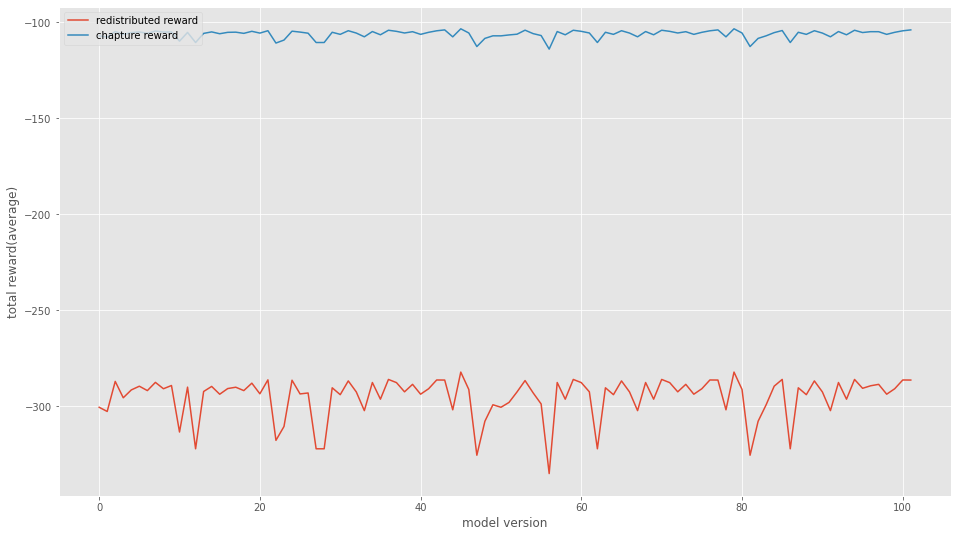

In [241]:
x = range(data_group_sorted4["model_version"].values.shape[0])
y1 = data_group_sorted4["average_re_reward"].values
y2 = data_group_sorted4["average_chapture_reward"].values
plt.figure(figsize = (16, 9))
plt.plot(x, y1, label = "redistributed reward")
plt.plot(x, y2, label = "chapture reward")
plt.legend(loc = "upper left")
plt.xlabel("model version")
plt.ylabel("total reward(average)")
plt.show()

In [255]:
data_chaptures = data[["match_id", "chaptures"]]

def chaptures_func(group_list):
    result = []
    for item in group_list:
        if len(item) > 0:
            single_chaptures = item.split(",")
            result.extend(single_chaptures)
    return ",".join(result)

data_chaptures_group = data_chaptures.groupby("match_id").agg({"chaptures": chaptures_func}).reset_index()
data_chaptures_group

,match_id,chaptures
0,0-0,"P,C,K"
1,0-1,"P,C,N,P,R,r,P,R,K"
2,0-10,"C,C,N,K"
3,0-2,"C,P,N,R,R,K,p"
4,0-3,"P,C,K"
...,...,...
787,99-1,"C,P,K"
788,99-2,"P,C,K"
789,99-3,"P,C,K"
790,99-4,"P,C,K"


In [261]:
data_chaptures_group["model_version"] = data_chaptures_group["match_id"].apply(lambda x: x.split("-")[0]).astype(int)
data_chaptures_group["match_index"] = data_chaptures_group["match_id"].apply(lambda x: x.split("-")[-1]).astype(int)
data_chaptures_group_sort = data_chaptures_group.groupby("model_version").apply(lambda x: x.sort_values(by = "match_index")).reset_index(drop = True)
data_chaptures_group_sort

,match_id,chaptures,model_version,match_idx,match_index
0,0-0,"P,C,K",0,0,0
1,0-1,"P,C,N,P,R,r,P,R,K",0,1,1
2,0-2,"C,P,N,R,R,K,p",0,2,2
3,0-3,"P,C,K",0,3,3
4,0-4,"P,P,p,R,C,A,B,R,C,N,B,p,A,K",0,4,4
...,...,...,...,...,...
787,101-2,"P,C,K",101,2,2
788,101-3,"P,C,K",101,3,3
789,101-4,"P,C,K",101,4,4
790,101-5,"P,C,K",101,5,5


In [265]:
counter_list = []
for i in range(len(data_chaptures_group_sort)):
    row = data_chaptures_group_sort.iloc[i]
    chapture_list = row["chaptures"].split(",")
    counter = Counter(chapture_list)
    counter_list.append(counter)

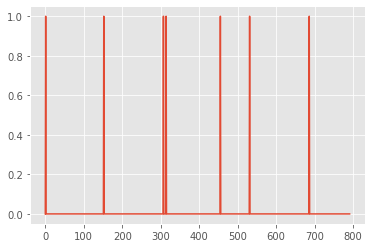

In [280]:
r_counter = [counter['r'] for counter in counter_list]
plt.plot(range(len(r_counter)), r_counter)

### 分配奖励到指定棋局(Double DQN Learning)

In [244]:
data_demo1 = data[data["match_id"] == "0-0"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
0,h0i2,False,,0.00,0,-1.8100
1,b2e2,False,,0.00,0,-1.9000
2,e0e1,False,P,-1.00,0,-3.7549
3,e1e0,False,,0.00,0,-3.9610
4,g3g4,False,C,-2.29,0,-84.8710
5,e0e1,False,,0.00,0,-93.0610
6,g4g5,True,K,-100.00,-1,-92.8549


In [245]:
data_demo1["raw_reward"] = [-1] * len(data_demo1)
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
0,h0i2,False,,0.00,-1,-1.8100
1,b2e2,False,,0.00,-1,-1.9000
2,e0e1,False,P,-1.00,-1,-3.7549
3,e1e0,False,,0.00,-1,-3.9610
4,g3g4,False,C,-2.29,-1,-84.8710
5,e0e1,False,,0.00,-1,-93.0610
6,g4g5,True,K,-100.00,-1,-92.8549


In [246]:
data_demo2 = data[data["match_id"] == "10-8"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo2["raw_reward"] = [-1] * len(data_demo2)
data_demo2

,action,done,chaptures,chapture_reward,raw_reward,re_reward
1117,h0i2,False,,0.00,-1,-1.8100
1118,b2e2,False,,0.00,-1,-1.9000
1119,e0e1,False,P,-1.00,-1,-3.7549
1120,a3a4,False,,0.00,-1,-5.5810
1121,e1e0,False,C,-2.29,-1,-9.1459
1122,a0a1,False,N,-2.00,-1,-8.7220
1123,i3i4,False,R,-4.29,-1,-11.9908
1124,a1f1,False,,0.00,-1,-10.3420
1125,f1a1,False,R,-4.29,-1,-89.3359
1126,e2a2,False,,0.00,-1,-94.8610


### 分配奖励到指定棋局(LSTM-Attention)

In [5]:
file_path = "./outputs/hoho_chess_data_20230905213354.xlsx"
chess_data = pd.read_excel(file_path)

In [6]:
contribution_file = "./outputs/hoho_action_contribution_maxstep15_win-lose-1_20230905213354.xlsx"
contribution_data = pd.read_excel(contribution_file)
contribution_data

,action_type,contribution
0,a0b0,0.065608
1,a0c0,0.061905
2,a0d0,0.000000
3,a0e0,0.000000
4,a0f0,0.000000
...,...,...
2081,e7c9,0.000000
2082,e7g5,0.000000
2083,g5e7,0.000000
2084,g9i7,0.000000


In [67]:
win = -1 # 赢为1，输为-1
hoho_match_data = chess_data[chess_data["match_id"] == "82-7"].copy()  # 随便选一场输的看看
actions_list = hoho_match_data["action"].values
hoho_match_contribution_data = contribution_data[contribution_data["action_type"].isin(actions_list)].copy()
total_contribution = hoho_match_contribution_data["contribution"].sum()
hoho_match_contribution_data["mine"] = hoho_match_contribution_data["contribution"].apply(lambda c: c / total_contribution * (len(hoho_match_contribution_data) * win))
hoho_match_contribution_data["alphago_zero"] = len(hoho_match_contribution_data) * [win]

In [68]:
hoho_match_contribution_data2 = hoho_match_contribution_data.rename(columns = {"action_type": "action"})

In [69]:
hoho_match_contribution_data2

,action,contribution,mine,alphago_zero
0,a0b0,0.065608,-1.088780,-1
8,a0a1,0.066551,-1.104414,-1
20,a1c1,0.065753,-1.091186,-1
204,b0a0,0.063889,-1.060244,-1
212,b0b1,0.055556,-0.921951,-1
223,b0c2,0.066449,-1.102728,-1
226,b1d1,0.044444,-0.737561,-1
253,b2b0,0.062500,-1.037195,-1
693,d1d3,0.044444,-0.737561,-1
904,e0f0,0.065432,-1.085853,-1


In [70]:
match_data_merge = pd.merge(hoho_match_data, hoho_match_contribution_data2, on = "action", how = "left")

In [71]:
match_data_merge

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,win,converted,jid,contribution,mine,alphago_zero
0,82-7,16939208404300,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,b0c2,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5...,0,NaN,0.00,0,0,82-7_16939208404300,0.066449,-1.102728,-1
1,82-7,16939208404301,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,h2h8,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404301,0.063492,-1.053659,-1
2,82-7,16939208404302,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,b2b0,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,0,C,-25.41,0,0,82-7_16939208404302,0.062500,-1.037195,-1
3,82-7,16939208404303,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,c0a2,RC1AKABNR/9/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404303,0.066516,-1.103845,-1
4,82-7,16939208404304,RC1AKABNR/7r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,a0a1,1C1AKABNR/R6r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c...,0,NaN,0.00,0,0,82-7_16939208404304,0.066551,-1.104414,-1
5,82-7,16939208404305,1C1AKABNR/Rc5r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/4...,f0e1,1C1AK1BNR/Rc2A2r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p...,0,NaN,0.00,0,0,82-7_16939208404305,0.066664,-1.106300,-1
6,82-7,16939208404306,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P1P/9/9/p1p1p1p1p/...,i3i4,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404306,0.066502,-1.103602,-1
7,82-7,16939208404307,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0a0,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404307,0.063889,-1.060244,-1
8,82-7,16939208404308,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,a0b0,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404308,0.065608,-1.088780,-1
9,82-7,16939208404309,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0b1,3AK1BNR/RC2A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404309,0.055556,-0.921951,-1


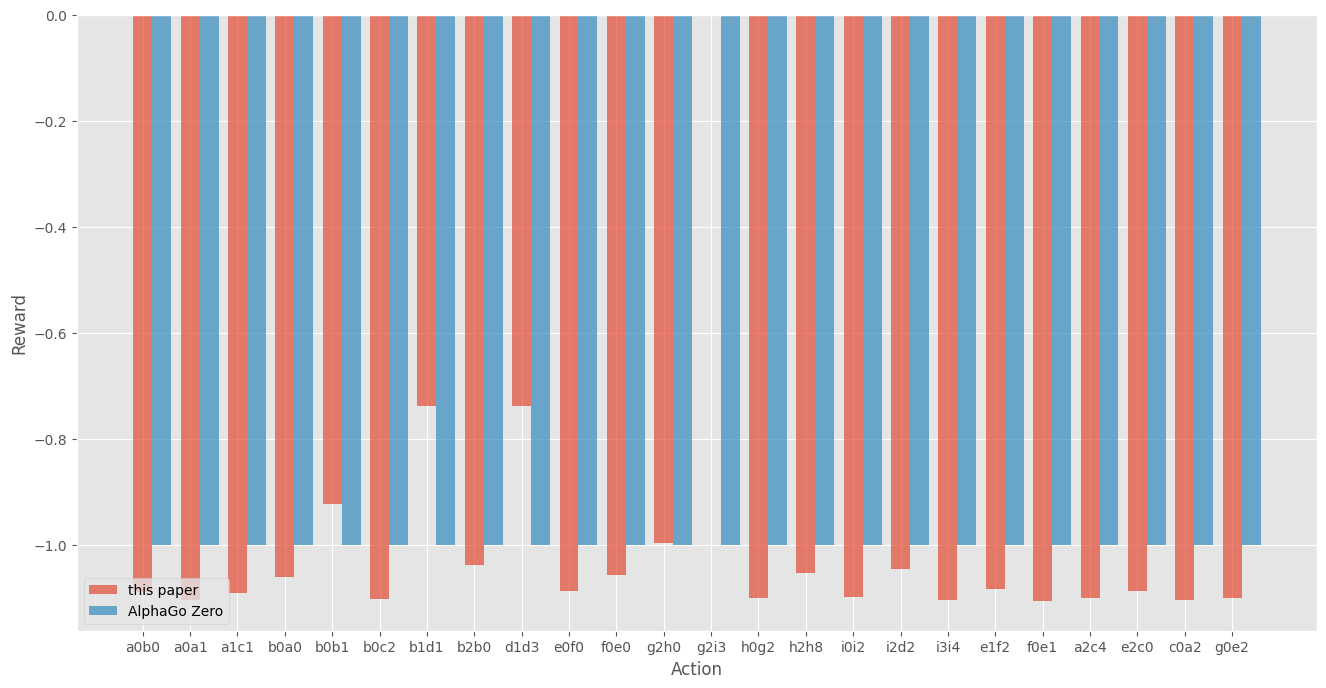

In [72]:
custom_ticks = list(range(len(hoho_match_contribution_data)))
custom_labels = hoho_match_contribution_data2["action"].values.tolist()
plt.figure(figsize = (16, 8))
plt.bar(range(len(hoho_match_contribution_data)), hoho_match_contribution_data["mine"], width=0.4, alpha=0.7, label='this paper' )
plt.bar([i + 0.4 for i in range(len(hoho_match_contribution_data))], hoho_match_contribution_data["alphago_zero"], width=0.4, alpha=0.7, label='AlphaGo Zero'  )
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Action')
plt.ylabel('Reward')
plt.legend(loc='lower left')
plt.show()